In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect = True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [9]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [10]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip dates in a previous year in the data set
trip = calc_temps('2016-08-01', '2016-08-07')
trip

[(72.0, 77.79545454545455, 83.0)]

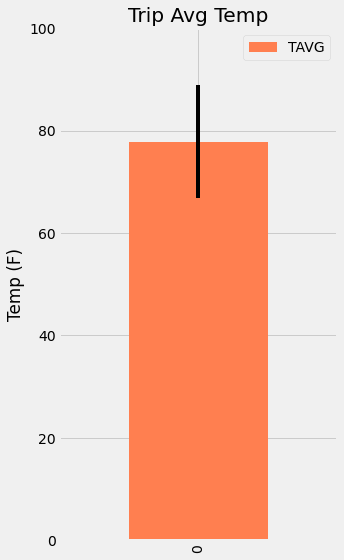

In [11]:
# Save to Pandas DataFrame
trip_df = pd.DataFrame(trip, columns = ["TMIN", "TAVG", "TMAX"])
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
trip_df.plot.bar(y = "TAVG", yerr=(trip_df["TMAX"]-trip_df["TMIN"]), title = "Trip Avg Temp", color = 'coral', ylim=(0,100), figsize=(5,8))
# Make it look like the example
plt.xticks()
plt.ylabel("Temp (F)")
plt.tight_layout()
plt.savefig("Images/avgtempbar_bonus2.png")

### Daily Rainfall Average

In [12]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
prcp = session.query(Measurement.date, Measurement.prcp,Measurement.station).filter((Measurement.date >= '2017-08-01') & (Measurement.date <= '2017-08-07')).order_by(-Measurement.prcp).all()
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
prcp_df = pd.DataFrame(prcp, columns = ["date", "rain", "station"])
prcp_df

,date,rain,station
0,2017-08-01,NaN,USC00516128
1,2017-08-05,NaN,USC00516128
2,2017-08-06,NaN,USC00516128
3,2017-08-02,0.25,USC00516128
4,2017-08-01,0.12,USC00514830
5,2017-08-05,0.06,USC00519281
6,2017-08-03,0.06,USC00516128
7,2017-08-02,0.05,USC00514830
8,2017-08-07,0.05,USC00516128
9,2017-08-04,0.04,USC00514830


In [13]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [14]:
# calculate the daily normals for your trip
dates = ["08-01", "08-02", "08-03", "08-04", "08-05", "08-06", "08-07"]
normals = []
for date in dates:
    normal = daily_normals(date)
    normals.append(normal)
# push each tuple of calculations into a list called `normals`
print(normals)



[[(67.0, 75.54, 83.0)], [(68.0, 75.60377358490567, 84.0)], [(70.0, 76.61111111111111, 85.0)], [(69.0, 76.71153846153847, 84.0)], [(69.0, 76.14814814814815, 82.0)], [(67.0, 76.25, 83.0)], [(71.0, 77.15686274509804, 83.0)]]


In [15]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame.from_records([t for lst in normals for t in lst], columns = ["TMIN", "TAVG", "TMAX"])
normals_df['dates'] = dates
normals_df.set_index('dates', inplace = True)
normals_df

,TMIN,TAVG,TMAX
dates,,,
08-01,67.0,75.540000,83.0
08-02,68.0,75.603774,84.0
08-03,70.0,76.611111,85.0
08-04,69.0,76.711538,84.0
08-05,69.0,76.148148,82.0
08-06,67.0,76.250000,83.0
08-07,71.0,77.156863,83.0


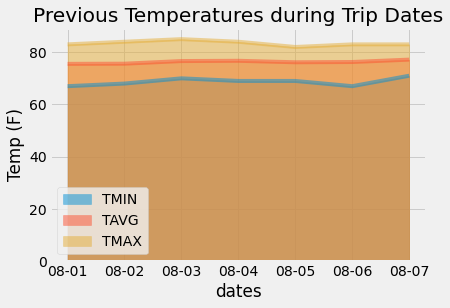

In [16]:
# Plot the daily normals as an area plot with `stacked=False`
normals_df.plot.area(stacked = False, title = "Previous Temperatures during Trip Dates")
plt.ylabel("Temp (F)")
plt.savefig("Images/temparea_bonus2.png")

## Close Session

In [17]:
session.close()